In [73]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime
import matplotlib.dates as mdates

In [74]:
def fetch_daily_balances():
    url = 'http://127.0.0.1:8000/energy/daily_balances'
    response = requests.get(url)
    data = response.json()
    return data

def fetch_weights():
    url = 'http://127.0.0.1:8000/energy/weights'
    response = requests.get(url)
    data = response.json()
    return data

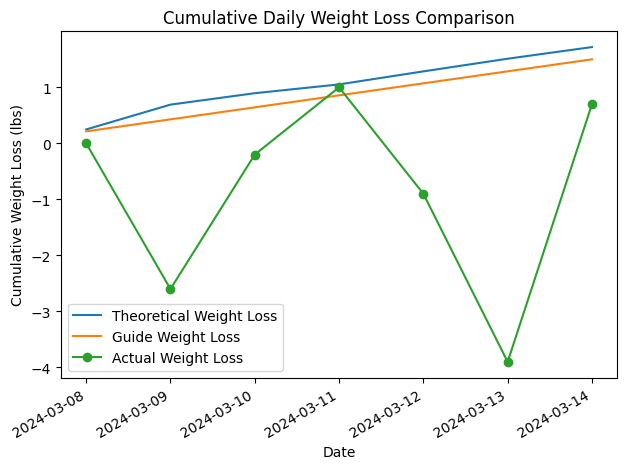

In [118]:
def fetch_data_and_prepare_dates(daily_balances, actual_weights):
    """Extract dates and data from the daily balances and actual weights, ensuring consistent date format."""
    balances_dates = [datetime.strptime(entry['date'], '%Y-%m-%d').date() for entry in daily_balances]
    balances = [entry['balance'] for entry in daily_balances]
    weights_dates = [datetime.fromisoformat(entry["timestamp"].rstrip("Z")).date() for entry in actual_weights]
    weights = [entry["weight"] for entry in actual_weights]
    return balances_dates, balances, weights_dates, weights

def calculate_cumulative_losses(balances, guide_value=750, calories_per_pound=3500):
    """Calculate the theoretical and guide cumulative weight losses."""
    deficits = [-balance for balance in balances]
    guide_deficits = [guide_value for _ in deficits]
    cumulative_deficits = np.cumsum(deficits)
    cumulative_guide_deficits = np.cumsum(guide_deficits)
    cumulative_theo_weight_loss = cumulative_deficits / calories_per_pound
    cumulative_guide_weight_loss = cumulative_guide_deficits / calories_per_pound
    return cumulative_theo_weight_loss, cumulative_guide_weight_loss

def interpolate_data_on_dates(all_dates, dates_with_data, data):
    """Interpolate data across all_dates, filling missing values for dates without explicit data."""
    plot_data = np.full(len(all_dates), np.nan)
    for date, value in zip(dates_with_data, data):
        idx = all_dates.index(date)
        plot_data[idx] = value
    return plot_data

def calculate_weight_change_from_initial(weights_dates, weights):
    """Calculate weight change from the initial weight for each recorded date."""
    if not weights:
        return [], []

    initial_weight = weights[0]
    weight_changes = [initial_weight - weight for weight in weights]

    return weights_dates, weight_changes

def interpolate_missing_values(dates, values):
    """Interpolate missing values in 'values' based on available data points."""
    # Find indices of non-NaN values
    non_nan_indices = np.where(~np.isnan(values))[0]
    # Interpolate missing values linearly
    interpolated_values = np.interp(range(len(values)), non_nan_indices, values[non_nan_indices])
    return interpolated_values

def plot_weight_loss(all_dates, theoretical, guide, actual):
    """Plot the theoretical, guide, and actual weight loss data."""
    plot_dates = [datetime.combine(d, datetime.min.time()) for d in all_dates]
    plt.plot(plot_dates, theoretical, label='Theoretical Weight Loss')
    plt.plot(plot_dates, guide, label='Guide Weight Loss')
    plt.plot(plot_dates, actual, label='Actual Weight Loss', marker='o', linestyle='-')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Cumulative Weight Loss (lbs)')
    plt.title('Cumulative Daily Weight Loss Comparison')
    plt.tight_layout()
    plt.show()

# Main program starts here

# Fetching data
daily_balances = fetch_daily_balances()
actual_weights = fetch_weights()

# Preparing data and dates
balances_dates, balances, weights_dates, weights = fetch_data_and_prepare_dates(daily_balances, actual_weights)

# Calculating cumulative losses
cumulative_theo_weight_loss, cumulative_guide_weight_loss = calculate_cumulative_losses(balances)

# Creating a unified list of all dates for plotting
all_dates = sorted(set(balances_dates + weights_dates))

# Interpolating theoretical and guide weight loss across all dates
plot_theo_weight_loss = interpolate_data_on_dates(all_dates, balances_dates, cumulative_theo_weight_loss)
plot_guide_weight_loss = interpolate_data_on_dates(all_dates, balances_dates, cumulative_guide_weight_loss)

# Calculating weight change from initial weight and interpolating actual weight loss across all dates
weights_dates_changes, weight_changes = calculate_weight_change_from_initial(weights_dates, weights)
plot_actual_weight_loss_raw = interpolate_data_on_dates(all_dates, weights_dates_changes, weight_changes)
plot_actual_weight_loss = interpolate_missing_values(all_dates, plot_actual_weight_loss_raw)

# Plotting the data
plot_weight_loss(all_dates, plot_theo_weight_loss, plot_guide_weight_loss, plot_actual_weight_loss)

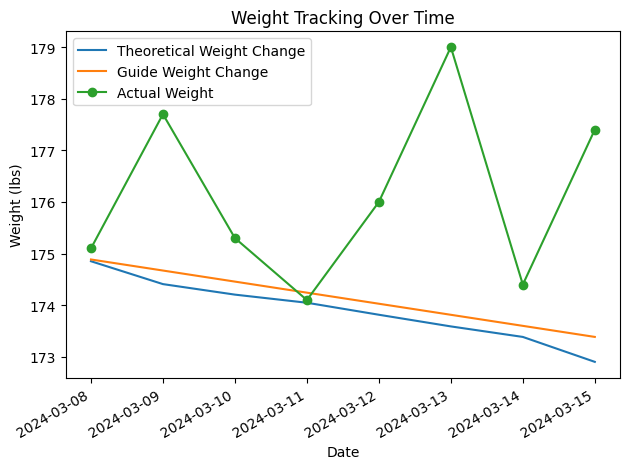

In [126]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def fetch_data_and_prepare_dates(daily_balances, actual_weights):
    balances_dates = [datetime.strptime(entry['date'], '%Y-%m-%d').date() for entry in daily_balances]
    balances = [entry['balance'] for entry in daily_balances]
    weights_dates = [datetime.fromisoformat(entry["timestamp"].rstrip("Z")).date() for entry in actual_weights]
    weights = [entry["weight"] for entry in actual_weights]
    return balances_dates, balances, weights_dates, weights

def calculate_cumulative_losses(balances, initial_weight, guide_value=750, calories_per_pound=3500):
    deficits = [-balance for balance in balances]
    guide_deficits = [guide_value for _ in deficits]
    cumulative_deficits = np.cumsum(deficits)
    cumulative_guide_deficits = np.cumsum(guide_deficits)
    cumulative_theo_weight_change = initial_weight - (cumulative_deficits / calories_per_pound)
    cumulative_guide_weight_change = initial_weight - (cumulative_guide_deficits / calories_per_pound)
    return cumulative_theo_weight_change, cumulative_guide_weight_change

def interpolate_data_on_dates(all_dates, dates_with_data, data):
    plot_data = np.full(len(all_dates), np.nan)
    for date, value in zip(dates_with_data, data):
        idx = all_dates.index(date)
        plot_data[idx] = value
    return plot_data

def interpolate_missing_values(dates, values):
    non_nan_indices = np.where(~np.isnan(values))[0]
    interpolated_values = np.interp(range(len(values)), non_nan_indices, values[non_nan_indices])
    return interpolated_values

def plot_weight_changes(all_dates, theoretical, guide, raw_weights):
    plot_dates = [datetime.combine(d, datetime.min.time()) for d in all_dates]
    plt.plot(plot_dates, theoretical, label='Theoretical Weight Change')
    plt.plot(plot_dates, guide, label='Guide Weight Change')
    plt.plot(plot_dates, raw_weights, label='Actual Weight', marker='o', linestyle='-')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Weight (lbs)')
    plt.title('Weight Tracking Over Time')
    plt.tight_layout()
    plt.show()

# Sample usage (You would need to define fetch_daily_balances and fetch_weights to run this)
daily_balances = fetch_daily_balances()
actual_weights = fetch_weights()
balances_dates, balances, weights_dates, weights = fetch_data_and_prepare_dates(daily_balances, actual_weights)
initial_weight = weights[0] if weights else 0
cumulative_theo_weight_change, cumulative_guide_weight_change = calculate_cumulative_losses(balances, initial_weight)
all_dates = sorted(set(balances_dates + weights_dates))
plot_theo_weight_change = interpolate_data_on_dates(all_dates, balances_dates, cumulative_theo_weight_change)
plot_guide_weight_change = interpolate_data_on_dates(all_dates, balances_dates, cumulative_guide_weight_change)
plot_raw_weights = interpolate_data_on_dates(all_dates, weights_dates, weights)
plot_raw_weights_interpolated = interpolate_missing_values(all_dates, plot_raw_weights)
plot_weight_changes(all_dates, plot_theo_weight_change, plot_guide_weight_change, plot_raw_weights_interpolated)
